I have identified mouse brain cell type-specific protein coding genes with pairwise dN/dS calculated from 92 mammalian species against human reference genome. Now I want to know which cell types have significantly higher dN/dS. This script calcuated these statistics. 

In [102]:
import numpy as np
import pandas as pd
import glob

In [103]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [104]:
pd.set_option('display.max_rows', 10)

# Representitive species pairwise dN/dS against mouse reference genome

In [105]:
from scipy import stats
import heapq

In [5]:
# Debug: July 9th, 2020: name change: avg_92species, not avg_93species
species_list=['human','rat','opposum','megabat','tasmaniandevil','cat','pig','avg_92species']
celltype_list=['neuron','endothelia','glia','astrocyte','microglia','oligodendrocyte']

### Descriptive Statistics: median and confidence interval

In [6]:
full_dict = {} # This dictionary stores dataframes for later use 
descriptive_stats_df = pd.DataFrame(
    columns=['Species','Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])
for species in species_list:
    full_dict[species] = {}
    for celltype in celltype_list:
        df=pd.read_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/'+species+'/'+celltype+'.tsv',
                       index_col=0, sep='\t')
        full_dict[species][celltype]=df
        arr=df.iloc[:,0].dropna().values
        med=np.median(arr)
        low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
        CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
        CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
        descriptive_stats_df = descriptive_stats_df.append(
            {'Species':species,'Celltype':celltype,'Median_dNdS':med,
             'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
            ignore_index=True)


In [7]:
# create an excel file to write descriptive stats
# future analysis with other reference genome can be added to this as a new tab:

# from openpyxl import load_workbook

# book = load_workbook(path)
# writer = pd.ExcelWriter(path, engine = 'openpyxl') # note the engine
# writer.book = book

# some_df.to_excel(writer, sheet_name = 'some_sheet_name')

# writer.save()
# writer.close()

path = '../results/celltype-specific_descriptive_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

descriptive_stats_df.to_excel(writer, sheet_name = 'mouse reference genome',index=False)

writer.save()
writer.close()


### Inferential statistics: Kruskal Wallis H and Mann Whitney U between celltypes

In [8]:
inferential_stats_df=pd.DataFrame(
    columns=['Species','Kruskal H NEG','Kruskal p NEG',
             'Kruskal H NEAMO','Kruskal p NEAMO',
             'Mann U NG','Mann p NG',
             'Mann U NE','Mann p NE',
             'Mann U EG','Mann p EG',
             'Mann U NA','Mann p NA',
             'Mann U NM','Mann p NM',
             'Mann U NO','Mann p NO'])

for species in species_list:

    h_NEG,kp_NEG=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['glia'])

    h_NEAMO,kp_NEAMO=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['astrocyte'],
        full_dict[species]['microglia'],
        full_dict[species]['oligodendrocyte'])
    
    # June 18, 2020: debug on Jan_20_2020-Confirming_w_Couple_Species-Ensembl98Mouse
    # June 24, 2020: debug stats.mannwhitneyu(), include alternative="two-sided", 
    # default "None" is deprecated and generate a smaller p value
    # Now avoid nan values influencing test results.
    # U statistics and p values from Mann Whitney's U test 
    # comparing Neuron-specific genes and Glia-specific genes' dN/dS ratios
    u_NG, mp_NG=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['glia'],
        alternative="two-sided")
    
    # similarly, compare neuron-specific genes and endothelia-specific genes
    u_NE, mp_NE=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        alternative="two-sided")
    
    # and endothelia vs glia
    u_EG, mp_EG=stats.mannwhitneyu(
        full_dict[species]['glia'],
        full_dict[species]['endothelia'],
        alternative="two-sided")
    
    # and neuron vs the three glial subtypes
    u_NA, mp_NA=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['astrocyte'],
        alternative="two-sided")
    
    u_NM, mp_NM=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['microglia'],
        alternative="two-sided")
    
    u_NO, mp_NO=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['oligodendrocyte'],
        alternative="two-sided")
    
    inferential_stats_df = inferential_stats_df.append(
            {'Species':species,'Kruskal H NEG':h_NEG,'Kruskal p NEG':kp_NEG,
            'Kruskal H NEAMO':h_NEAMO,'Kruskal p NEAMO':kp_NEAMO,
            'Mann U NG':u_NG,'Mann p NG':mp_NG,
            'Mann U NE':u_NE,'Mann p NE':mp_NE,
            'Mann U EG':u_EG,'Mann p EG':mp_EG,
            'Mann U NA':u_NA,'Mann p NA':mp_NA,
            'Mann U NM':u_NM,'Mann p NM':mp_NM,
            'Mann U NO':u_NO,'Mann p NO':mp_NO},
            ignore_index=True)

In [9]:
# Create and write to excel file for inferential stats
path = '../results/celltype-specific_inferential_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

inferential_stats_df.to_excel(writer, sheet_name = 'mouse reference genome', index=False)

writer.save()
writer.close()

# All species cell type-specific genes' pairwise dN/dS against mouse genome

In [10]:
all_species_dict={}
for celltype in ['neuron','endothelia','glia']:
    all_species_dict[celltype]=pd.read_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/all_92species/'
                                           +celltype+'.tsv',index_col=0, sep='\t')

    

In [11]:
n_array=all_species_dict['neuron'].to_numpy()
n_array=n_array[~np.isnan(n_array)]
e_array=all_species_dict['endothelia'].to_numpy()
e_array=e_array[~np.isnan(e_array)]
g_array=all_species_dict['glia'].to_numpy()
g_array=g_array[~np.isnan(g_array)]

In [12]:
n_array.shape
e_array.shape
g_array.shape

(86260,)

(61687,)

(80131,)

In [13]:
stats.mannwhitneyu(n_array,e_array,alternative="two-sided")
stats.mannwhitneyu(n_array,g_array,alternative="two-sided")
stats.mannwhitneyu(e_array,g_array,alternative="two-sided")
stats.kruskal(n_array,e_array,g_array)

MannwhitneyuResult(statistic=1843208704.5, pvalue=0.0)

MannwhitneyuResult(statistic=2401686399.0, pvalue=0.0)

MannwhitneyuResult(statistic=2478863691.5, pvalue=0.33667696357096166)

KruskalResult(statistic=15068.010565252689, pvalue=0.0)

In [109]:
neg_stats_df = pd.DataFrame(
    columns=['Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])
neg_cell_list=['Neuron','Endothelial Cell','Glial Cell']
for i, arr in enumerate([n_array,e_array,g_array]):
        med=np.median(arr)
        low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
        CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
        CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
        neg_stats_df = neg_stats_df.append(
            {'Celltype':neg_cell_list[i],'Median_dNdS':med,
             'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
            ignore_index=True)

In [110]:
neg_stats_df

,Celltype,Median_dNdS,Confidence_Interval_Low,Confidence_Interval_High
0,Neuron,0.070163,0.069543,0.070742
1,Endothelial Cell,0.118995,0.118036,0.119894
2,Glial Cell,0.120077,0.119231,0.120914


# Visualization

In [ ]:
# import statsmodels.api as sm
# import matplotlib.ticker as mtick

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import seaborn as sns

In [15]:
sns.__version__

'0.10.1'

In [16]:
matplotlib.rcParams['figure.dpi']= 300

In [17]:
from copy import deepcopy

In [18]:
graph_dict = deepcopy(full_dict)
graph_df = pd.DataFrame(columns=['dNdS','Species','Celltype'])
for celltype in celltype_list:
    for species in species_list:
        graph_dict[species][celltype].columns=['dNdS']
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Species=species)
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Celltype=celltype)
        graph_df=graph_df.append(graph_dict[species][celltype][['dNdS','Species','Celltype']],ignore_index=True)

In [19]:
sns.set_style('ticks')

In [20]:
palette={'endothelia':'tab:blue','glia':'tab:green','neuron':'tab:red','oligodendrocyte':'lightblue','astrocyte':'lightgreen','microglia':'tab:orange'}

In [208]:
for species in species_list:
    data=graph_df[graph_df['Species']==species]
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot()
    ax = sns.boxplot(y="dNdS", x="Celltype", data=data,showfliers=False,palette=palette)
    ax.set_yscale('log')
    ax.set_ylim(0.0005,1)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    sns.despine()
    stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",
                        box_pairs=[("endothelia", "neuron"),
                                   ("endothelia", "glia"),
                                   ("glia","neuron"),
                                   ("astrocyte","neuron"),
                                   ("microglia","neuron"),
                                   ("oligodendrocyte","neuron"),
                                   ("astrocyte","microglia"),
                                   ("microglia","oligodendrocyte"),
                                   ("astrocyte","oligodendrocyte")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
    pd.DataFrame(stats[1]).to_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/MannWhitney/'+species+'.tsv',sep='\t',index=False)
    ax.set_xlabel("Cell Types")
    ax.set_ylabel("dN/dS of Cell Type-specific Genes")
    plt.savefig('../figures/MannWhitney/mouse_reference_genome/'+species+'.pdf')
    plt.close()

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.862e-33 U_stat=3.146e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=8.239e-01 U_stat=4.182e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.510e-10 U_stat=2.697e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.572e-15 U_stat=2.541e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.650e-37 U_stat=4.093e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.490e-02 U_stat=1.841e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.718e-14 U_stat=3.404e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.521e-46 U_stat=3.200e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.71

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.979e-21 U_stat=3.297e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=3.888e-01 U_stat=4.237e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.783e-12 U_stat=2.700e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.655e-21 U_stat=2.803e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.711e-29 U_stat=4.210e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.270e-04 U_stat=1.899e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.991e-10 U_stat=3.311e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=5.127e-42 U_stat=3.268e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.07

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.756e-15 U_stat=2.633e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.237e-01 U_stat=3.136e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=6.053e-02 U_stat=2.219e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=5.420e-04 U_stat=1.696e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.509e-11 U_stat=3.576e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.090e-02 U_stat=1.415e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.801e-07 U_stat=2.726e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.898e-12 U_stat=2.928e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.26

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.403e-12 U_stat=8.307e+04
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=7.255e-01 U_stat=1.136e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.030e-03 U_stat=7.551e+04
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.254e-11 U_stat=7.246e+04
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.021e-15 U_stat=1.070e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.709e-04 U_stat=4.684e+04
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.131e-10 U_stat=7.123e+04
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=9.761e-24 U_stat=8.482e+04
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.16

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.632e-17 U_stat=2.218e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=7.556e-01 U_stat=2.800e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.268e-02 U_stat=1.964e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.891e-04 U_stat=1.598e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.841e-18 U_stat=2.907e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.643e-02 U_stat=1.234e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.971e-12 U_stat=2.088e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.832e-19 U_stat=2.396e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.19

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=9.887e-33 U_stat=2.880e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.307e-01 U_stat=3.906e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.593e-09 U_stat=2.514e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.410e-16 U_stat=2.397e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.151e-36 U_stat=3.742e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.560e-03 U_stat=1.760e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.364e-13 U_stat=3.141e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.938e-43 U_stat=2.956e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.58

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=5.878e-34 U_stat=2.816e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.929e-01 U_stat=3.727e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.558e-09 U_stat=2.438e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.978e-15 U_stat=2.395e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.286e-40 U_stat=3.581e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.615e-03 U_stat=1.715e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.699e-16 U_stat=2.987e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.089e-47 U_stat=2.866e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.44

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.325e-40 U_stat=4.079e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=7.193e-01 U_stat=5.725e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.683e-14 U_stat=3.491e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.052e-24 U_stat=3.643e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.555e-43 U_stat=5.369e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.060e-04 U_stat=2.404e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=5.749e-16 U_stat=4.234e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=7.102e-59 U_stat=4.228e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=9.07

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

In [85]:
graph_df

,dNdS,Species,Celltype
0,0.174468,human,neuron
1,0.230926,human,neuron
2,0.424793,human,neuron
3,0.303478,human,neuron
4,0.232940,human,neuron
...,...,...,...
36759,0.077988,avg_92species,oligodendrocyte
36760,0.052152,avg_92species,oligodendrocyte
36761,0.036849,avg_92species,oligodendrocyte
36762,0.108997,avg_92species,oligodendrocyte


In [84]:
graph_df[graph_df['Celltype'].isin(['neuron','glia','endothelia'])]

,dNdS,Species,Celltype
0,0.174468,human,neuron
1,0.230926,human,neuron
2,0.424793,human,neuron
3,0.303478,human,neuron
4,0.232940,human,neuron
...,...,...,...
21591,0.065470,avg_92species,glia
21592,0.397521,avg_92species,glia
21593,0.133719,avg_92species,glia
21594,0.092123,avg_92species,glia


[None]

(0.0005, 1)

[Text(0, 0, 'human'),
 Text(0, 0, 'rat'),
 Text(0, 0, 'opposum'),
 Text(0, 0, 'megabat'),
 Text(0, 0, 'tasmaniandevil'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'pig'),
 Text(0, 0, 'avg_92species')]

Text(0.5, 0, 'Species compared against mouse reference genome')

Text(0, 0.5, 'dN/dS of Cell Type-specific Genes')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

opposum_neuron v.s. opposum_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.756e-15 U_stat=2.633e+05
megabat_neuron v.s. megabat_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.403e-12 U_stat=8.307e+04
tasmaniandevil_neuron v.s. tasmaniandevil_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.560e-17 U_stat=2.209e+05
cat_neuron v.s. cat_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=9.887e-33 U_stat=2.880e+05
pig_neuron v.s. pig_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=5.878e-34 U_stat=2.816e+05
avg_92species_neuron v.s. avg_92species_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.325e-40 U_stat=4.079e+05
human_neuron v.s. human_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.862e-33 U_stat=3.146e+05
rat_neuron v.s. rat_endothelia: Mann-Whitney-Wilcoxon test t

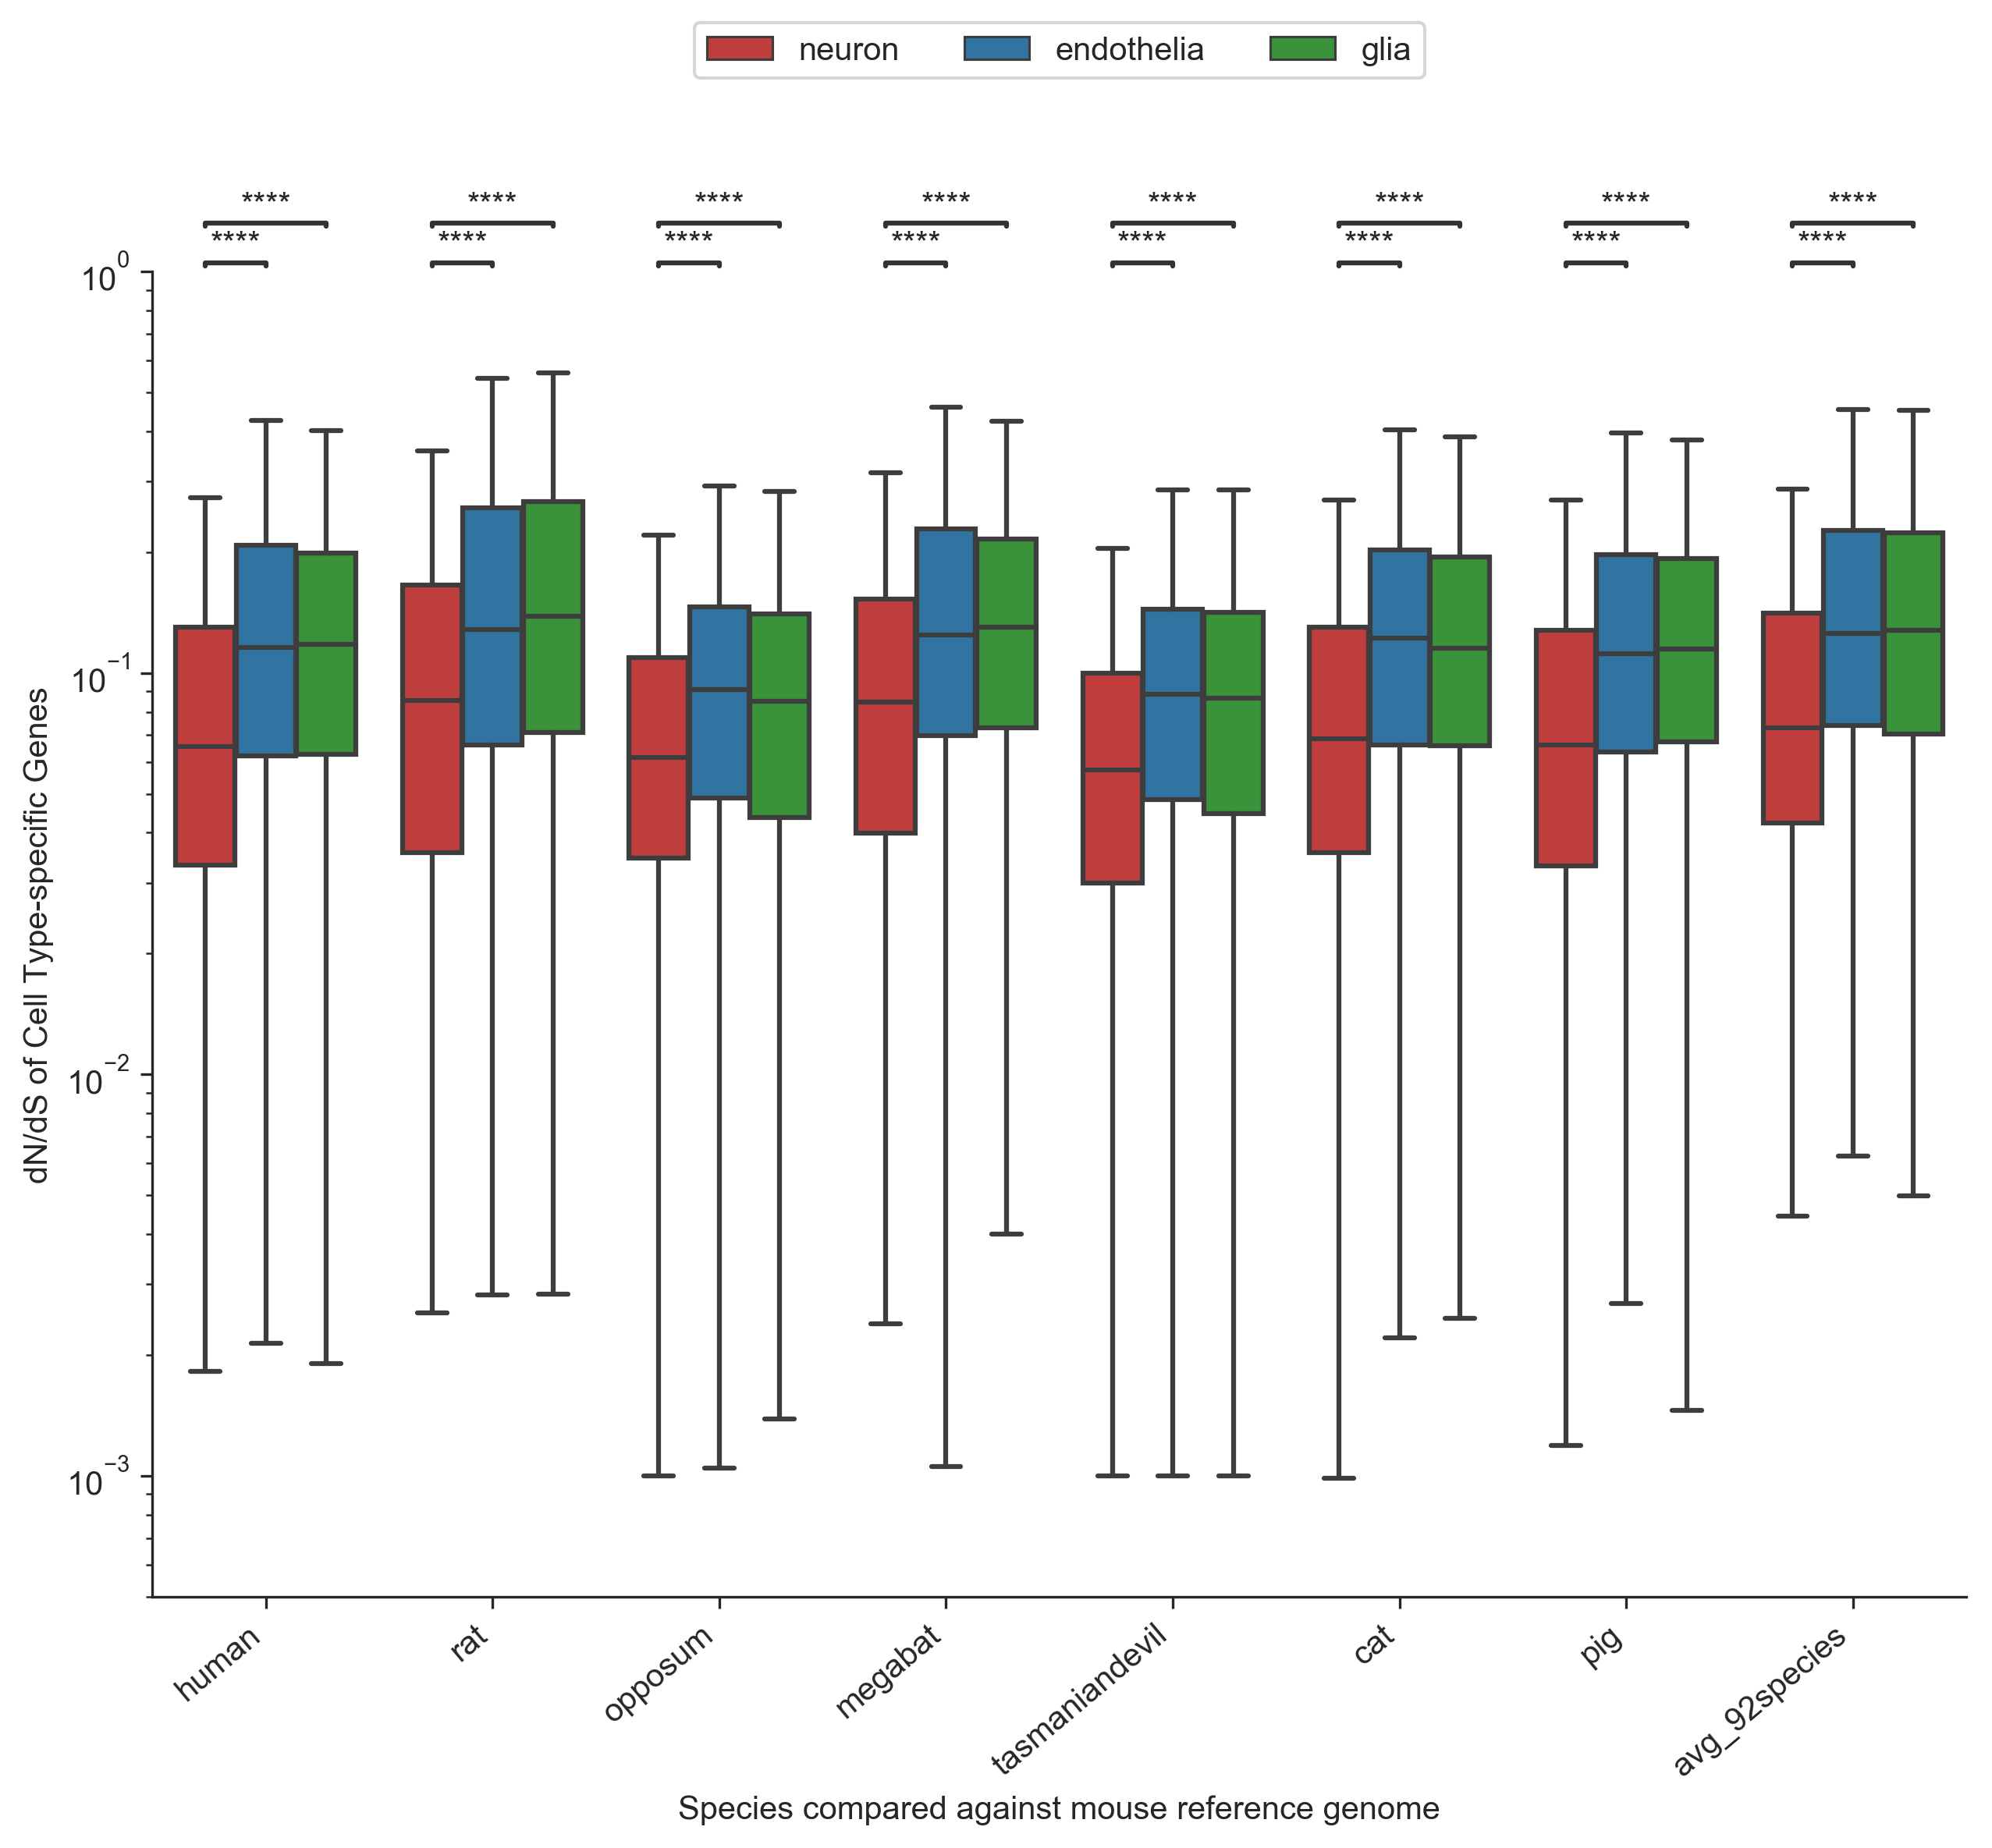

In [95]:
neg_df=graph_df[graph_df['Celltype'].isin(['neuron','glia','endothelia'])]
neg_df=neg_df[neg_df['dNdS']!=0]
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
ax = sns.boxplot(x="Species", y="dNdS", hue="Celltype", data=neg_df, showfliers=False, palette=palette)
sns.despine()
ax.set(yscale='log')
ax.set_ylim(0.0005,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.),ncol=3)
ax.set_xlabel("Species compared against mouse reference genome")
ax.set_ylabel("dN/dS of Cell Type-specific Genes")
stats = add_stat_annotation(ax=ax,data=neg_df,x="Species", y="dNdS", hue="Celltype",
                        box_pairs=[(('human',"endothelia"), ('human',"neuron")),
                                   (('human','glia'),('human','neuron')),
                                   (('rat',"endothelia"), ('rat',"neuron")),
                                   (('rat','glia'),('rat','neuron')),
                                   (('opposum',"endothelia"), ('opposum',"neuron")),
                                   (('opposum','glia'),('opposum','neuron')),
                                   (('megabat',"endothelia"), ('megabat',"neuron")),
                                   (('megabat','glia'),('megabat','neuron')),
                                   (('tasmaniandevil',"endothelia"), ('tasmaniandevil',"neuron")),
                                   (('tasmaniandevil','glia'),('tasmaniandevil','neuron')),
                                   (('cat',"endothelia"), ('cat',"neuron")),
                                   (('cat','glia'),('cat','neuron')),
                                   (('pig',"endothelia"), ('pig',"neuron")),
                                   (('pig','glia'),('pig','neuron')),
                                   (('avg_92species',"endothelia"), ('avg_92species',"neuron")),
                                   (('avg_92species','glia'),('avg_92species','neuron')),],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
# plt.savefig('../figures/mouse.boxplots.pdf')
plt.show()

[None]

(0.0005, 1)

[Text(0, 0, 'human'),
 Text(0, 0, 'rat'),
 Text(0, 0, 'opposum'),
 Text(0, 0, 'megabat'),
 Text(0, 0, 'tasmaniandevil'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'pig'),
 Text(0, 0, 'avg_92species')]

Text(0.5, 0, 'Species compared against mouse reference genome')

Text(0, 0.5, 'dN/dS of Cell Type-specific Genes')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

human_neuron v.s. human_endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.862e-33 U_stat=3.146e+05


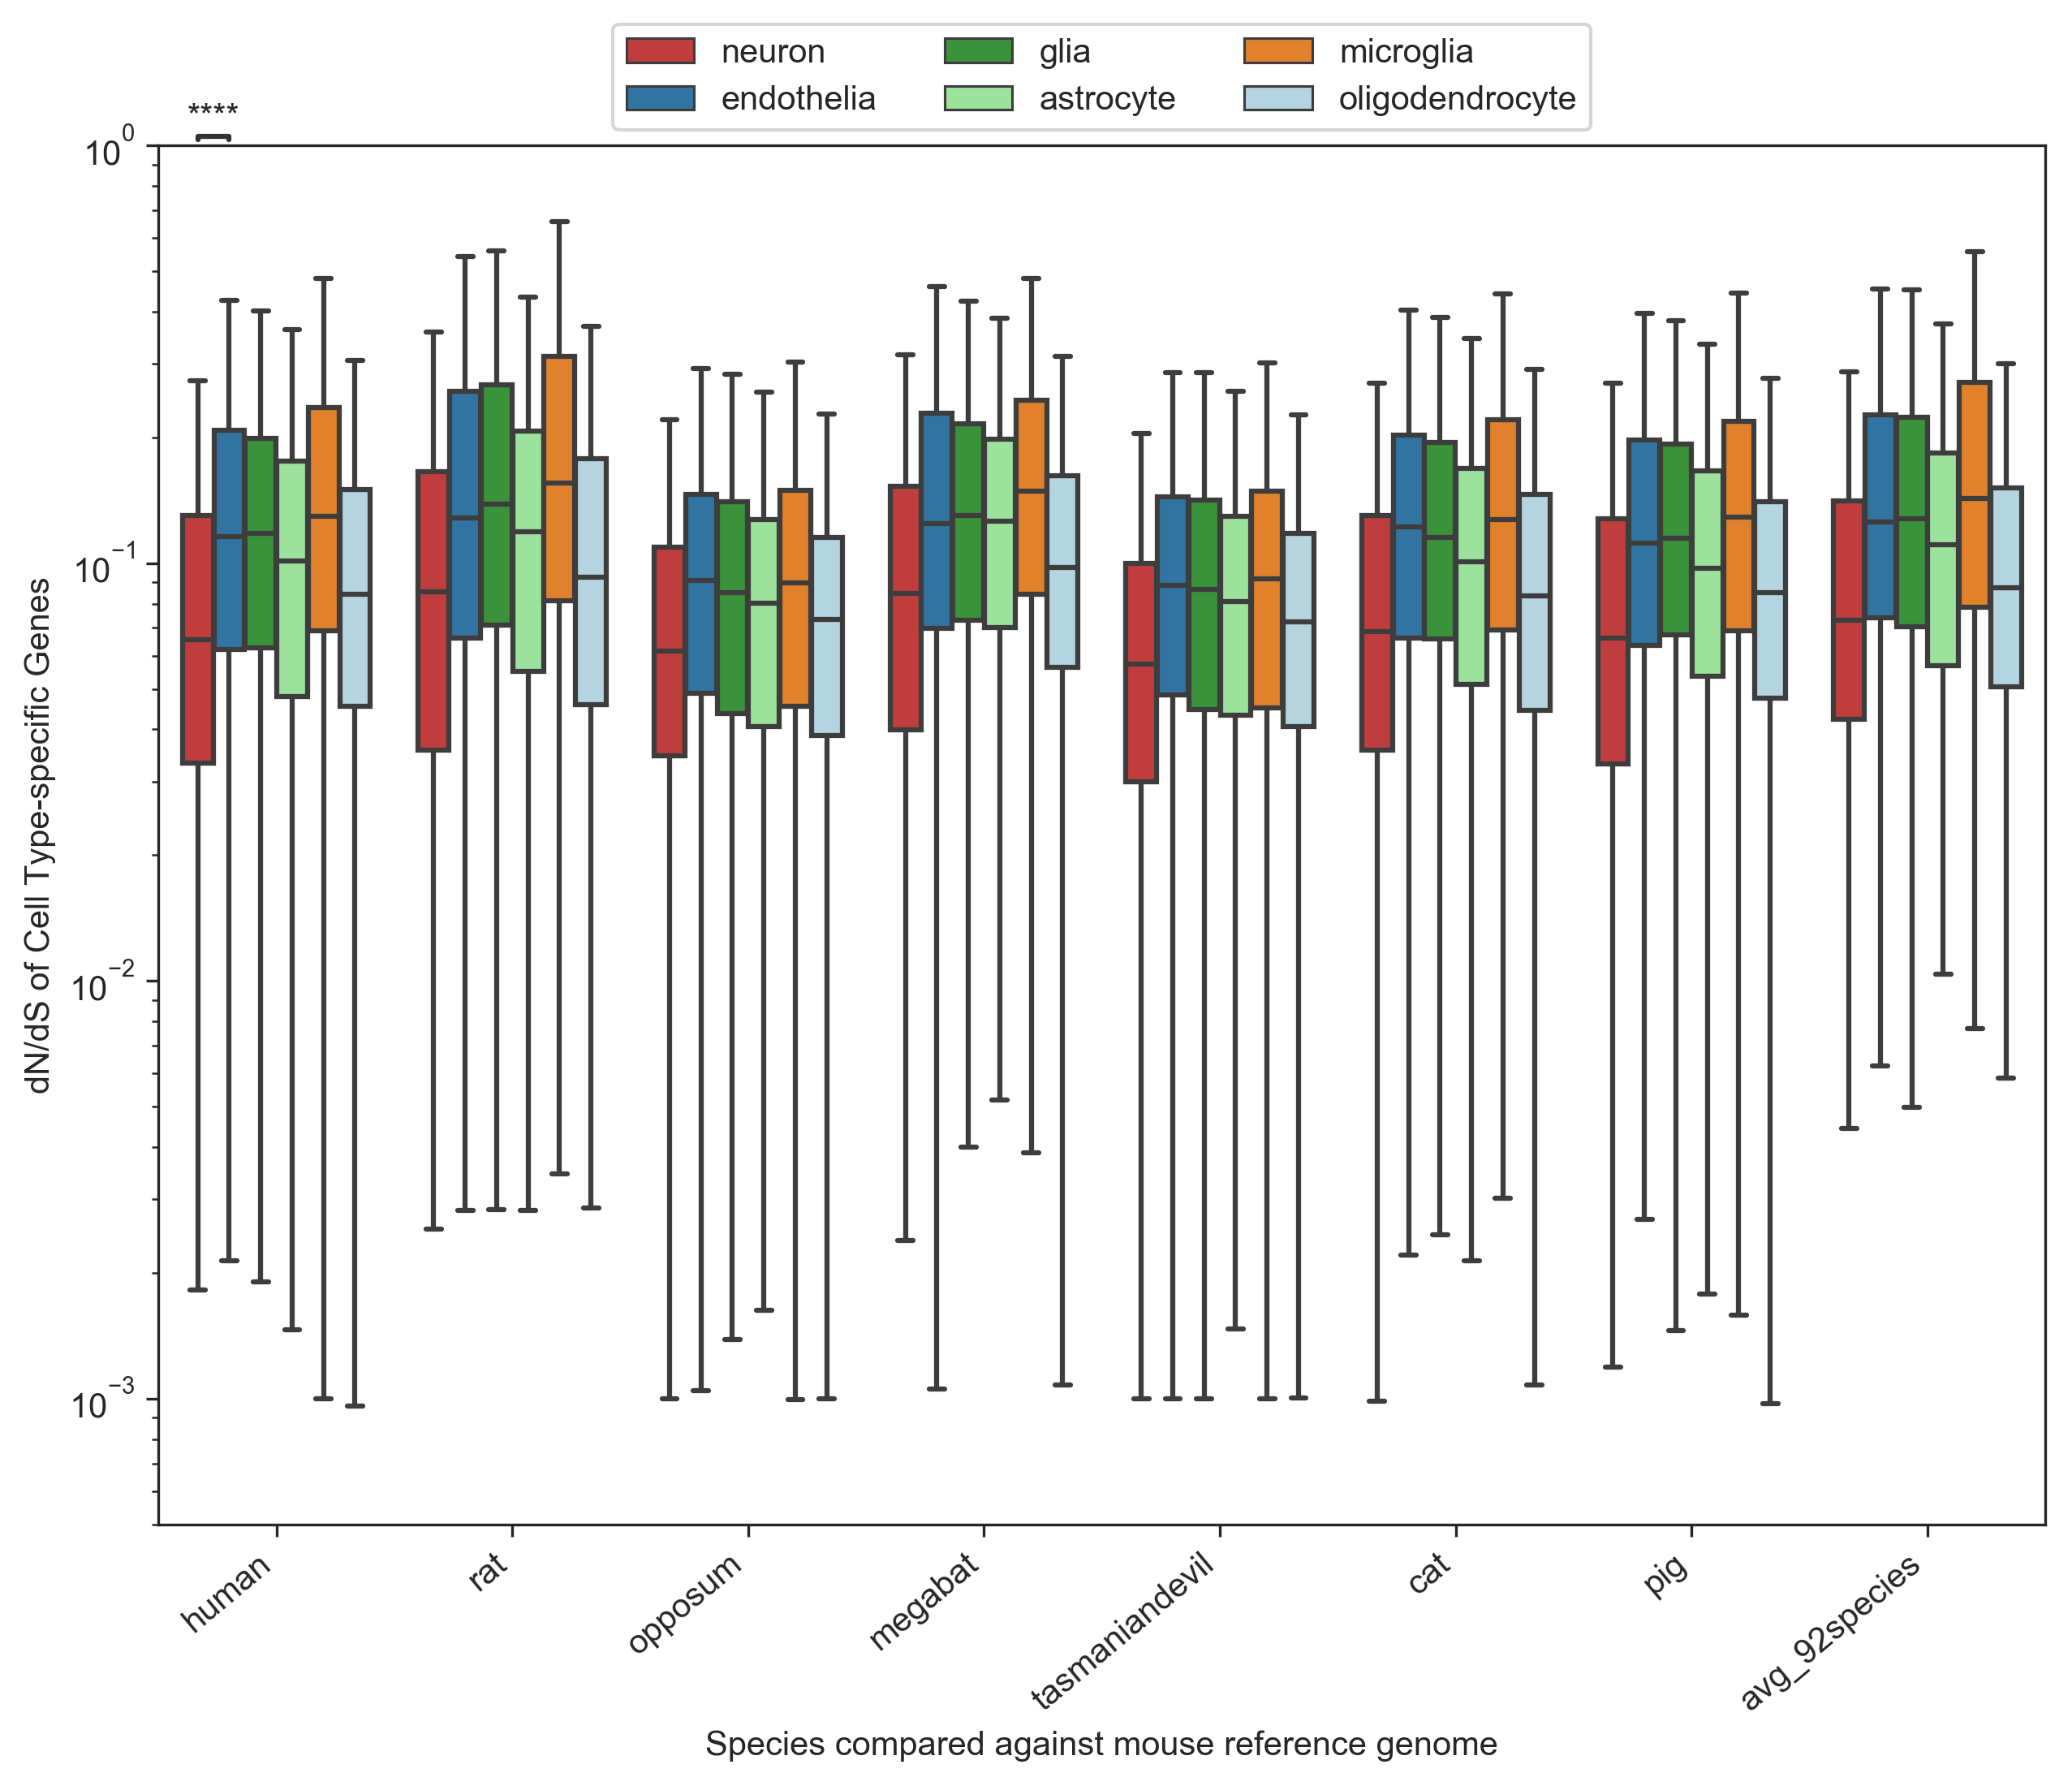

In [81]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
ax = sns.boxplot(x="Species", y="dNdS", hue="Celltype", data=graph_df[graph_df['dNdS']!=0], showfliers=False, palette=palette)
ax.set(yscale='log')
ax.set_ylim(0.0005,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.1),ncol=3)
ax.set_xlabel("Species compared against mouse reference genome")
ax.set_ylabel("dN/dS of Cell Type-specific Genes")
plt.savefig('../figures/mouse.boxplots.pdf')
plt.show()

[None]

(0.0005, 1)

[Text(0, 0, 'human'),
 Text(0, 0, 'rat'),
 Text(0, 0, 'opposum'),
 Text(0, 0, 'megabat'),
 Text(0, 0, 'tasmaniandevil'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'pig'),
 Text(0, 0, 'avg_92species')]

Text(0.5, 0, 'Species compared against mouse reference genome')

Text(0, 0.5, 'dN/dS of Cell Type-specific Genes')

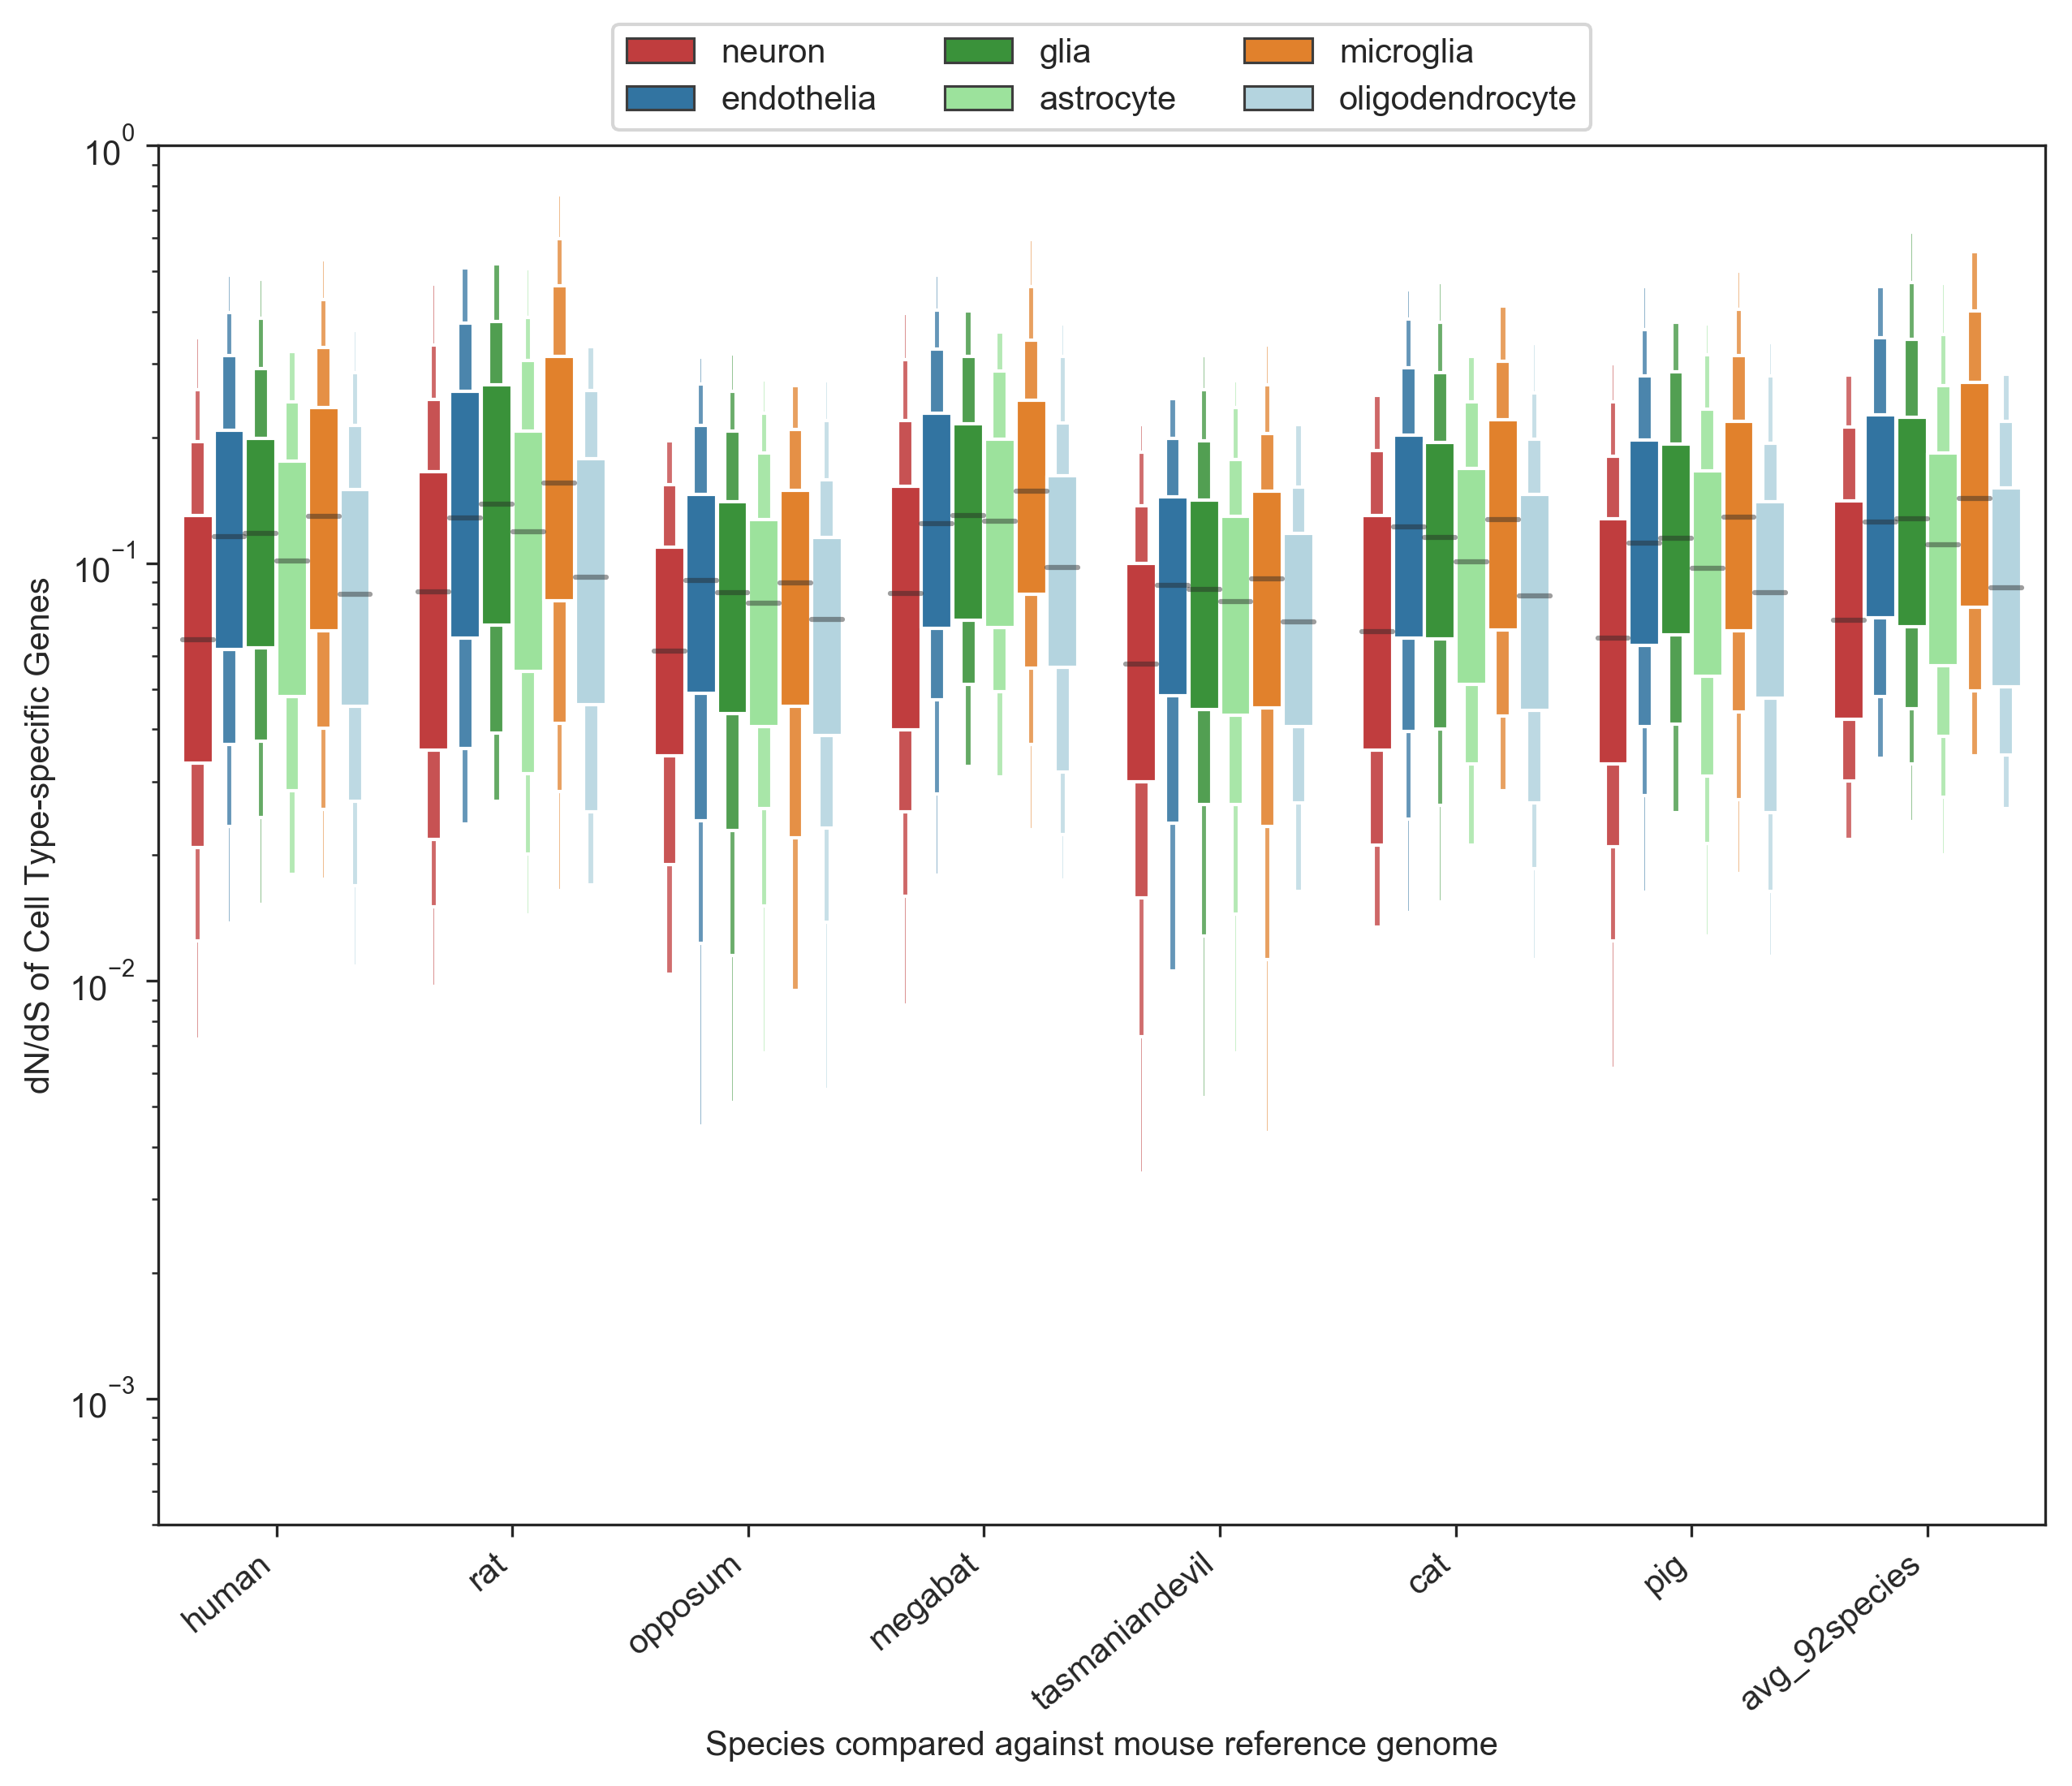

In [76]:
palette={'endothelia':'tab:blue','glia':'tab:green','neuron':'tab:red','oligodendrocyte':'lightblue','astrocyte':'lightgreen','microglia':'tab:orange'}
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
ax = sns.boxenplot(x="Species", y="dNdS", hue="Celltype", data=graph_df, showfliers=False, palette=palette)
ax.set(yscale='log')
ax.set_ylim(0.0005,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.1),ncol=3)
ax.set_xlabel("Species compared against mouse reference genome")
ax.set_ylabel("dN/dS of Cell Type-specific Genes")
# plt.savefig('../figures/mouse.boxplots.pdf')
plt.show()

In [21]:
n_df=pd.DataFrame()
n_df['dNdS']=pd.Series(n_array)
n_df['celltype']='Neuron'
e_df=pd.DataFrame()
e_df['dNdS']=pd.Series(e_array)
e_df['celltype']='Endothelial Cell'
g_df=pd.DataFrame()
g_df['dNdS']=pd.Series(g_array)
g_df['celltype']='Glial Cell'
df=pd.concat([e_df,g_df,n_df])

[None]

(0.0008, 6)

[Text(0, 0.5, 'all pairwise dN/dS scores'), Text(0.5, 0, 'Cell Types')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Endothelial Cell v.s. Glial Cell: Mann-Whitney-Wilcoxon test two-sided P_val=3.367e-01 U_stat=2.479e+09
Glial Cell v.s. Neuron: Mann-Whitney-Wilcoxon test two-sided P_val=0.000e+00 U_stat=4.510e+09
Endothelial Cell v.s. Neuron: Mann-Whitney-Wilcoxon test two-sided P_val=0.000e+00 U_stat=3.478e+09


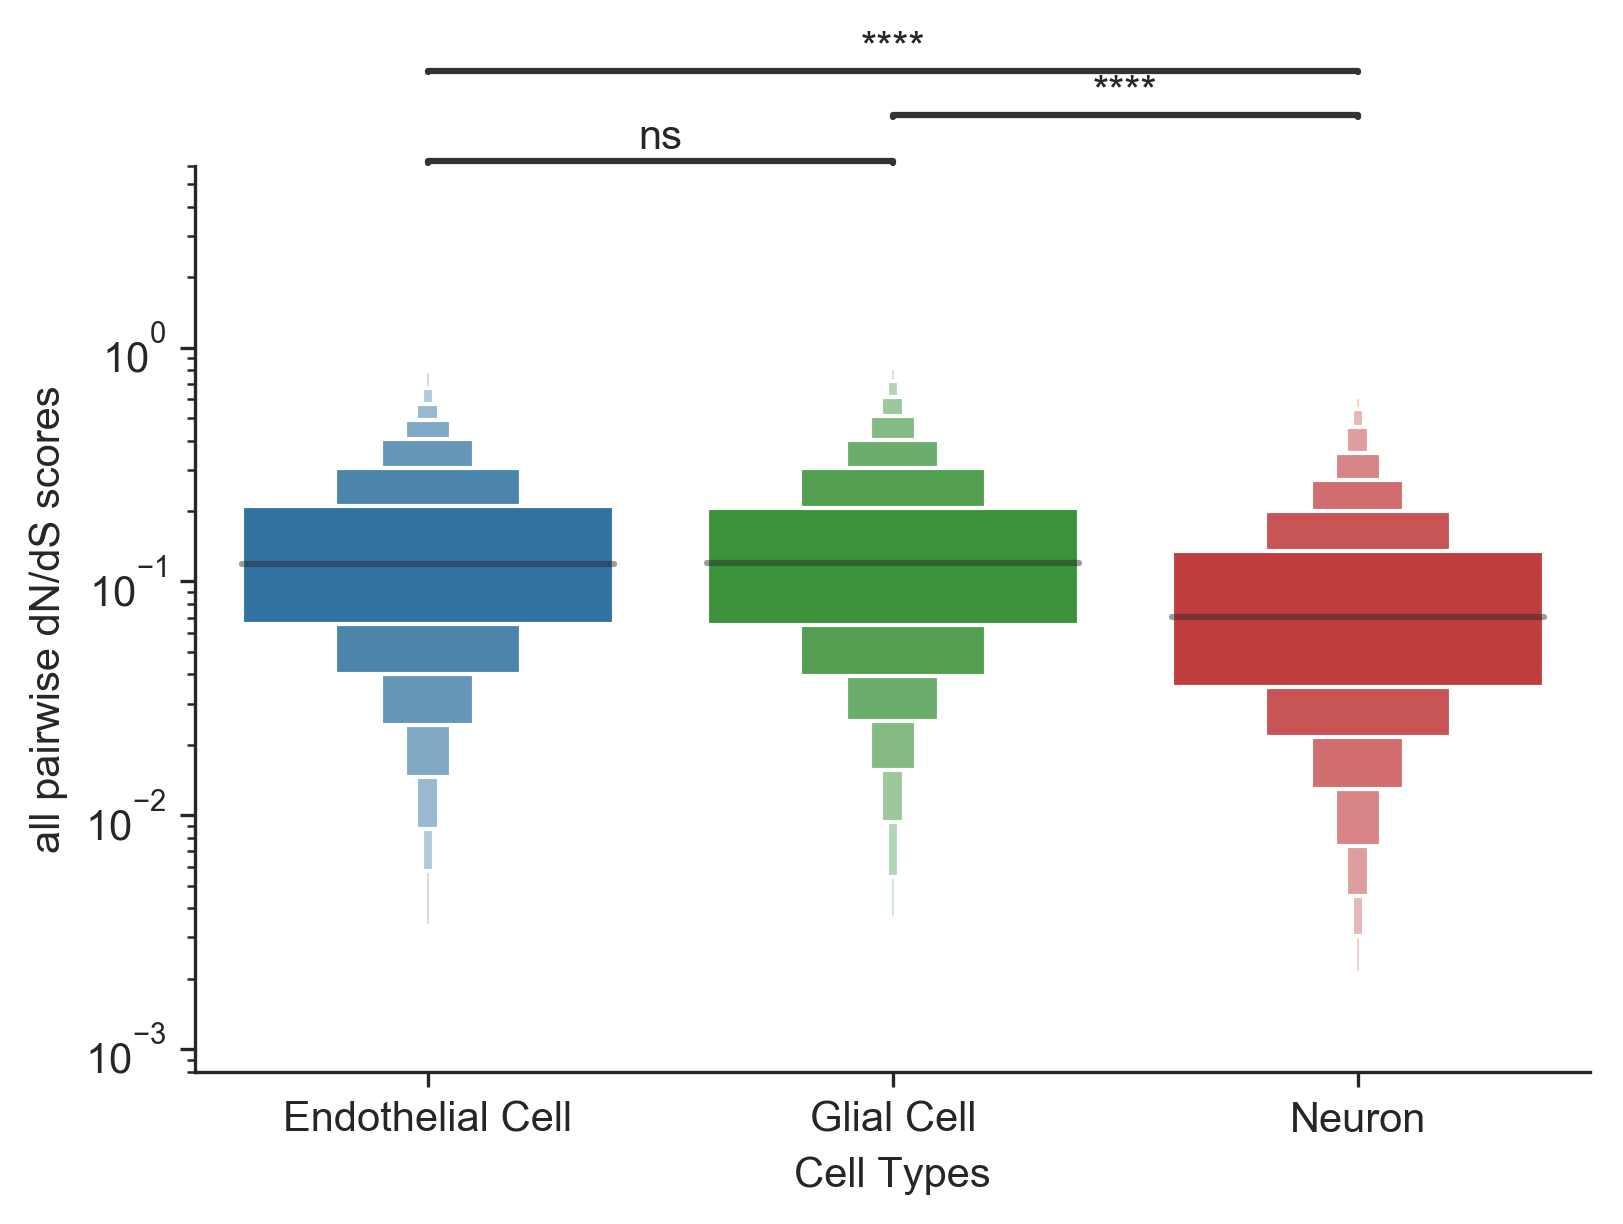

In [42]:
palette={'Endothelial Cell':'tab:blue','Glial Cell':'tab:green','Neuron':'tab:red'}

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(yscale='log')
ax.set_ylim(0.0008,6)

ax=sns.boxenplot(x='celltype',y='dNdS',data=df,palette=palette,showfliers=False,outlier_prop=0)
ax.set(ylabel='all pairwise dN/dS scores',xlabel='Cell Types')
sns.despine()
stats = add_stat_annotation(ax=ax,data=df,x="celltype", y="dNdS",
                        box_pairs=[("Endothelial Cell", "Neuron"),
                                   ("Endothelial Cell", "Glial Cell"),
                                   ("Glial Cell","Neuron")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
plt.savefig('../figures/MannWhitney/mouse_reference_genome/all_92species.pdf')
plt.show()

[None]

(0.0008, 6)

[Text(0, 0.5, 'all pairwise dN/dS scores'), Text(0.5, 0, 'Cell Types')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Endothelial Cell v.s. Glial Cell: Mann-Whitney-Wilcoxon test two-sided P_val=3.367e-01 U_stat=2.479e+09
Glial Cell v.s. Neuron: Mann-Whitney-Wilcoxon test two-sided P_val=0.000e+00 U_stat=4.510e+09
Endothelial Cell v.s. Neuron: Mann-Whitney-Wilcoxon test two-sided P_val=0.000e+00 U_stat=3.478e+09


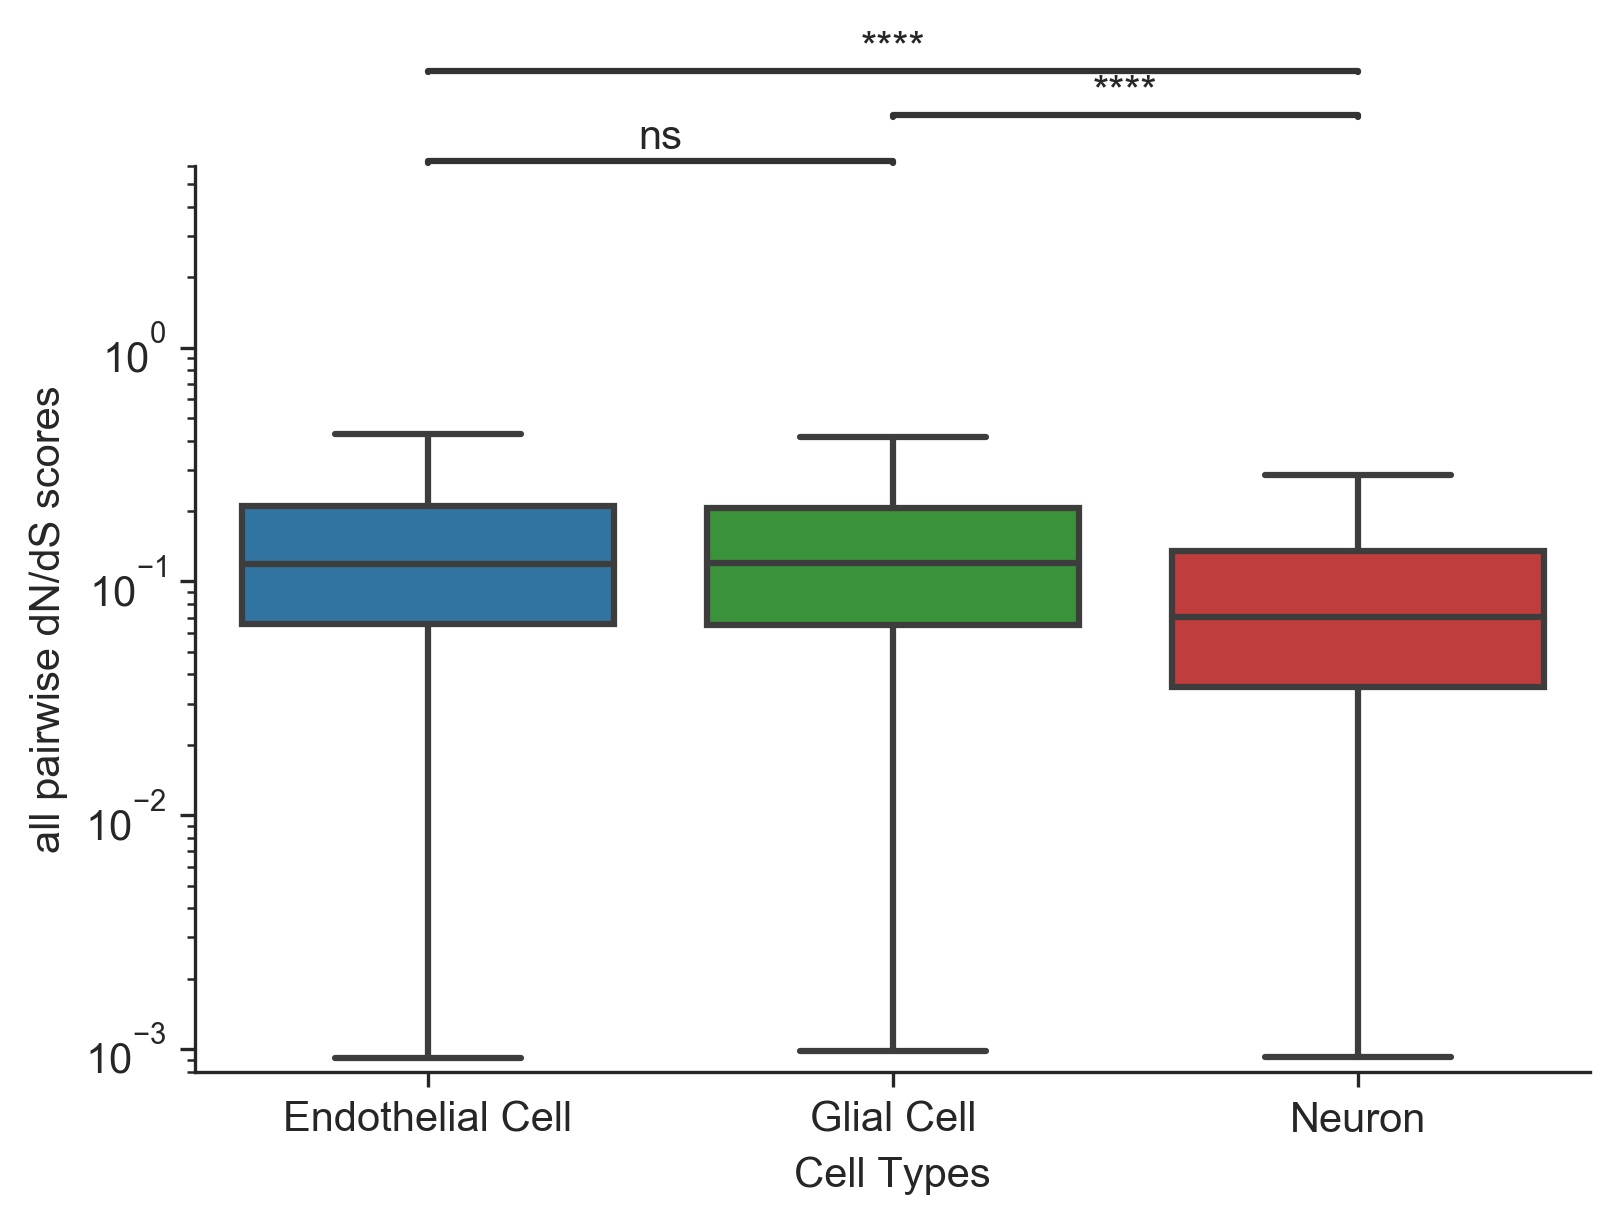

In [96]:
palette={'Endothelial Cell':'tab:blue','Glial Cell':'tab:green','Neuron':'tab:red'}

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(yscale='log')
ax.set_ylim(0.0008,6)

# there is one dNdS for endothelia that is 0, so I need to take it out before drawing botplot
ax=sns.boxplot(x='celltype',y='dNdS',data=df[df['dNdS'] !=0 ],palette=palette,showfliers=False,whis=1.5)
ax.set(ylabel='all pairwise dN/dS scores',xlabel='Cell Types')
sns.despine()
stats = add_stat_annotation(ax=ax,data=df,x="celltype", y="dNdS",
                        box_pairs=[("Endothelial Cell", "Neuron"),
                                   ("Endothelial Cell", "Glial Cell"),
                                   ("Glial Cell","Neuron")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
#plt.savefig('../figures/MannWhitney/mouse_reference_genome/all_92species.pdf')
plt.show()

In [67]:
df

,dNdS,celltype
0,0.174546,Endothelial Cell
1,0.263261,Endothelial Cell
2,0.217485,Endothelial Cell
3,0.190044,Endothelial Cell
4,0.215500,Endothelial Cell
...,...,...
86255,0.215925,Neuron
86256,0.219966,Neuron
86257,0.202996,Neuron
86258,0.161032,Neuron


In [69]:
df[df['dNdS'] !=0 ]

,dNdS,celltype
0,0.174546,Endothelial Cell
1,0.263261,Endothelial Cell
2,0.217485,Endothelial Cell
3,0.190044,Endothelial Cell
4,0.215500,Endothelial Cell
...,...,...
86255,0.215925,Neuron
86256,0.219966,Neuron
86257,0.202996,Neuron
86258,0.161032,Neuron
